In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pprint import pprint
import math


In [2]:
# params
seed = 42

Небольшой датасет, предоставляющий данные по кредитам, использующими недвижимость заемщика в качестве залога. 

In [4]:
#read the data
df = pd.read_csv('hmeq.csv',
                 header = [0], sep = ',')

df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


Уже видим пропуски

### Список факторов:
|    | Variable Name   | Description                         | Codings                                                 |
|---:|:----------------|:------------------------------------|:--------------------------------------------------------|
|  0 | BAD             | target                              | 1 = applicant defaulted on loan or seriously delinquent |
|  1 |                 |                                     | 0 = applicant paid loan                                 |
|  2 | LOAN            | Amount of the loan request          |                                                         |
|  3 | MORTDUE         | Amount due on existing mortgage     |                                                         |
|  4 | VALUE           | Value of current property           |                                                         |
|  5 | REASON          | Motivation of the loan              | DebtCon = debt consolidation                            |
|  6 |                 |                                     | HomeImp = home improvement                              |
|  7 | JOB             | Occupational categories             |                                                         |
|  8 | YOJ             | Years at present job                |                                                         |
|  9 | DEROG           | Number of major derogatory reports  |                                                         |
| 10 | DELINQ          | Number of delinquent credit lines   |                                                         |
| 11 | CLAGE           | Age of oldest credit line in months |                                                         |
| 12 | NINQ            | Number of recent credit inquiries   |                                                         |
| 13 | CLNO            | Number of credit lines              |                                                         |
| 14 | DEBTINC         | Debt-to-income ratio                |                                                         |

In [12]:
#get description of factors as tabulated markdown
df_names = pd.read_excel('description.xlsx', header = [0])
df_names = df_names.fillna("")
#print(df_names.to_markdown())

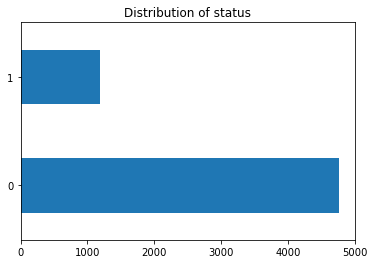

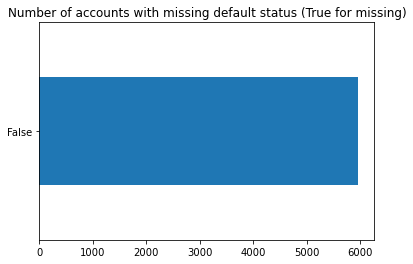

In [14]:
df.BAD.value_counts().plot.barh()
plt.title("Distribution of status")
plt.show()

df.BAD.isnull().value_counts().plot.barh()
plt.title("Number of accounts with missing default status (True for missing)")
plt.show()

Для единообразия нотации, создадим новую зависимую переменную target:

In [15]:
df.rename(columns = {"BAD":"target"}, inplace = True)

Выделяем test&train сеты

In [16]:
X = df.loc[:, df.columns != 'target']
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)


Сохраняем данные

In [ ]:
!pip install pyarrow
!pip install fastparquet

In [17]:
# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train.to_parquet('./samples/X_train.parquet')
X_test.to_parquet('./samples/X_test.parquet')
# переводим pd.Series в pd.DataFrame для удобного экспорта
pd.DataFrame(y_train).to_parquet('./samples/y_train.parquet')
pd.DataFrame(y_test).to_parquet('./samples/y_test.parquet')

#списки категориальных и количественных переменных
df_number_of_uniques = df.nunique()
presumably_continuous = df_number_of_uniques[df_number_of_uniques >= 15]
presumably_discrete = df_number_of_uniques[df_number_of_uniques < 15]

presumably_continuous_names = list(presumably_continuous.index)
presumably_discrete_names = list(presumably_discrete.index)

with open('factors.json', 'w') as f:
    json.dump({'cat_vals': presumably_discrete_names, "num_vals": presumably_continuous_names}, f)

A subdirectory or file samples already exists.


### Статистики

In [18]:
print(f'Количество наблюдений: {X.shape[0]}')
print(f'Количество наблюдений, где имеются данные о дефолте или его отсутствии: {X[y.isnull() == False].shape[0]}')
print(f'Количество факторов: {X.shape[1]}')
print(f'Количество целевых событий: {y.sum()}')
print(f'Доля целевых событий: {y.sum() / X[y.isnull() == False].shape[0] * 100}%')

Количество наблюдений: 5960
Количество наблюдений, где имеются данные о дефолте или его отсутствии: 5960
Количество факторов: 12
Количество целевых событий: 1189
Доля целевых событий: 19.949664429530202%


### Пропуски

В датасете присутствуют пропуски (но не в зависимой переменной)

In [19]:
for col in X.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X[col].isna().sum()} или {X[col].isna().sum() / df.shape[0] * 100}%')

Количество пропусков по фактору LOAN:
	0 или 0.0%
Количество пропусков по фактору MORTDUE:
	518 или 8.691275167785236%
Количество пропусков по фактору VALUE:
	112 или 1.8791946308724832%
Количество пропусков по фактору REASON:
	252 или 4.228187919463087%
Количество пропусков по фактору JOB:
	279 или 4.681208053691275%
Количество пропусков по фактору YOJ:
	515 или 8.640939597315436%
Количество пропусков по фактору DEROG:
	708 или 11.879194630872483%
Количество пропусков по фактору DELINQ:
	580 или 9.731543624161073%
Количество пропусков по фактору CLAGE:
	308 или 5.167785234899329%
Количество пропусков по фактору NINQ:
	510 или 8.557046979865772%
Количество пропусков по фактору CLNO:
	222 или 3.724832214765101%
Количество пропусков по фактору DEBTINC:
	1267 или 21.258389261744966%


### Визуальный анализ

Изготовим маску для осмысленного наименования факторов:

In [21]:
from pprint import pprint 
df_names_short = df_names[["Variable Name", "Description"]][(df_names["Variable Name"] != "")&(df_names["Description"] != "")]
short_names = df_names_short["Variable Name"]
short_names = short_names.str.upper()
meaningful_names = df_names_short["Description"]
names_mask = dict(zip(short_names, meaningful_names))

pprint(names_mask)

{'BAD': 'target',
 'CLAGE': 'Age of oldest credit line in months',
 'CLNO': 'Number of credit lines',
 'DEBTINC': 'Debt-to-income ratio',
 'DELINQ': 'Number of delinquent credit lines',
 'DEROG': 'Number of major derogatory reports',
 'JOB': 'Occupational categories',
 'LOAN': 'Amount of the loan request',
 'MORTDUE': 'Amount due on existing mortgage',
 'NINQ': 'Number of recent credit inquiries',
 'REASON': 'Motivation of the loan',
 'VALUE': 'Value of current property',
 'YOJ': 'Years at present job'}


И маски для осмысленных обозначений кодов категориальных переменных:

In [22]:

cat_vals_reason_mask = {
    "DebtCon" : "Debt consolidation",
    "HomeImp" : "Housing conditions improvement"
}

dict_of_masks = {
    "REASON" : cat_vals_reason_mask,
}

In [25]:
X_cat = X.copy()
for col_name in dict_of_masks.keys():
    X_cat[col_name] = X_cat[col_name].replace(dict_of_masks[col_name])

numeric


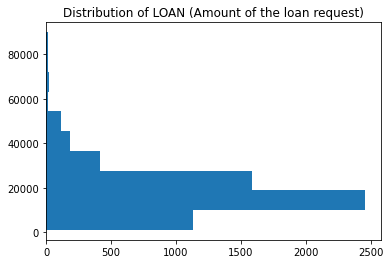

numeric


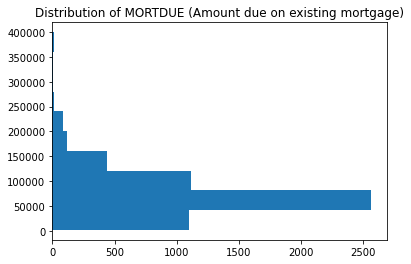

numeric


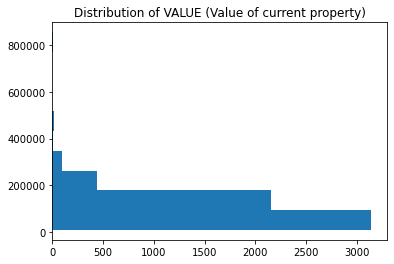

categorical


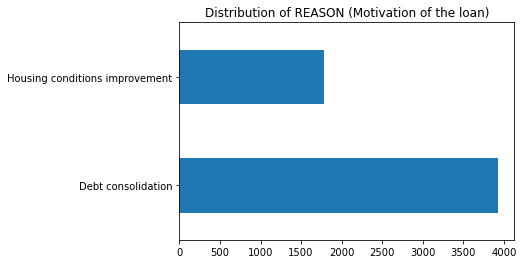

categorical


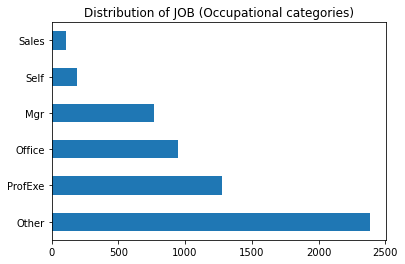

numeric


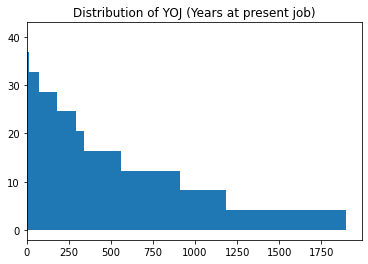

numeric


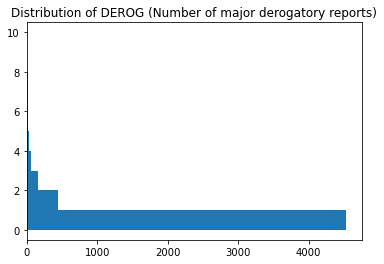

numeric


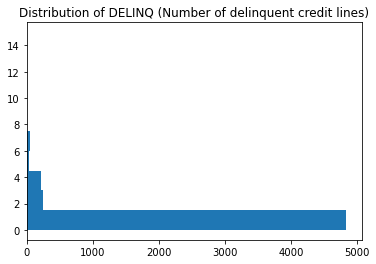

numeric


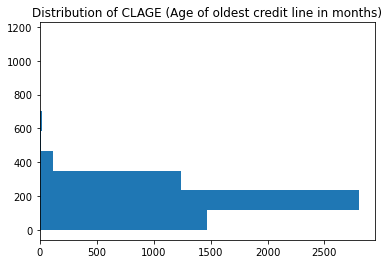

numeric


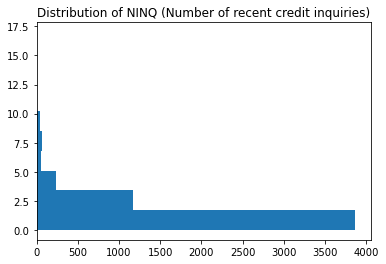

numeric


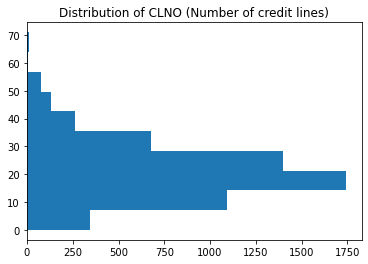

numeric


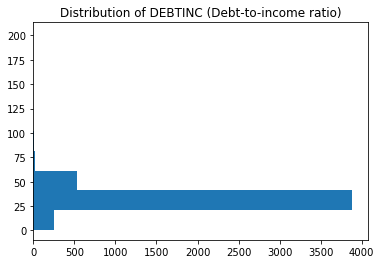

In [26]:
def plot_categorical(column, column_name, names_mask):
    column.value_counts().plot.barh()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_mixed(column, column_name, names_mask):
    print("This is a column mixed of both numeric and non-numeric values")
    check_numeric = column.str.isnumeric()
    check_numeric[check_numeric.isnull()] = True
    check_numeric[column.isnull()] = False

    plt.hist(column[check_numeric], orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]}) without non-numeric values')
    plt.show()

    check_numeric.value_counts().plot.barh()
    plt.title(f'Distribution of non-missing (numeric) values in {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_numeric(column, column_name, names_mask):
    plt.hist(column, orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()    

def plot_datetime(column, column_name, names_mask):
    column.hist()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()
    
def check_mixed_or_categorical(column):
    if is_string_dtype(column) == False:
        return(False)
    else:
        check_numeric = column.str.isnumeric()
        check_numeric[check_numeric.isnull()] = True
        check_numeric[column.isnull()] = False
        if len(column[check_numeric]) == 0:
            return("categorical")
        else:
            return("mixed")

def check_factor_plotting_type(column, column_name, names_mask):
    if column.dtype == pd.Series([np.datetime64("1995-05-05")]).dtype:
        return("datetime")
    elif check_mixed_or_categorical(column) != False:
        return(check_mixed_or_categorical(column))
    else:
        return("numeric")

def plot_all(column, column_name, names_mask, presumably_discrete_names = presumably_discrete_names):
    map_functions_to_types = {
        "categorical" : plot_categorical,
        "mixed" : plot_mixed,
        "numeric" : plot_numeric, 
        "datetime" : plot_datetime
    }
    
    type_checked = check_factor_plotting_type(column, column_name, names_mask)
    print(type_checked)
    map_functions_to_types[type_checked](column, column_name, names_mask)


for col in X_cat.columns:
    
    plot_all(X_cat[col], col, names_mask)


Из графиков можно сделать вывод о большом количестве выбросов

### Выбросы

Пробуем их идентифицировать и убрать используя z-score. Видим, что устранение аутлаеров с z-score > 3 позволяет устранить проблему с аутлаерами в большинстве случаев. Исключением являются переменные DEROG и DELINQ



Share of outliers in LOAN (Amount of the loan request) is 0.01593959731543626
Mass of outliers in LOAN (Amount of the loan request) is 0.05794497017677536
numeric


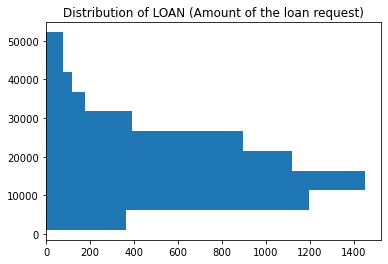

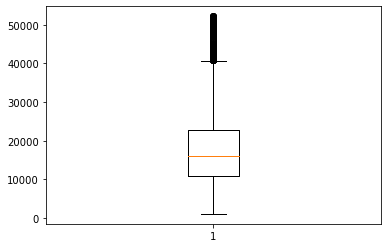



Share of outliers in MORTDUE (Amount due on existing mortgage) is 0.10167785234899329
Mass of outliers in MORTDUE (Amount due on existing mortgage) is 0.0556943856071449
numeric


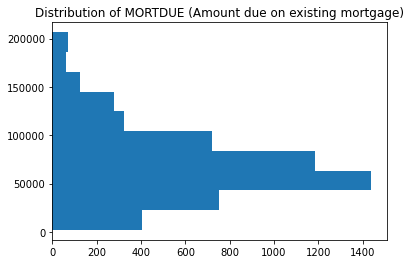

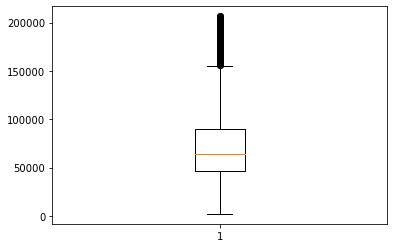



Share of outliers in VALUE (Value of current property) is 0.03372483221476508
Mass of outliers in VALUE (Value of current property) is 0.051491316750279514
numeric


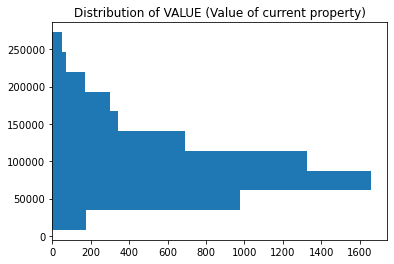

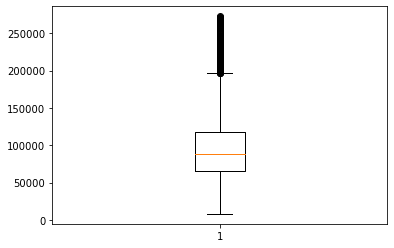



Share of outliers in DEROG (Number of major derogatory reports) is 0.14060402684563755
Mass of outliers in DEROG (Number of major derogatory reports) is 0.4353029169783097
numeric


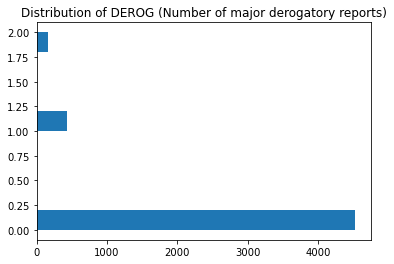

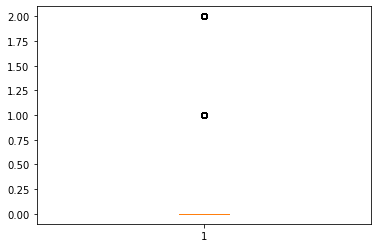



Share of outliers in DELINQ (Number of delinquent credit lines) is 0.12550335570469795
Mass of outliers in DELINQ (Number of delinquent credit lines) is 0.36269644334160467
numeric


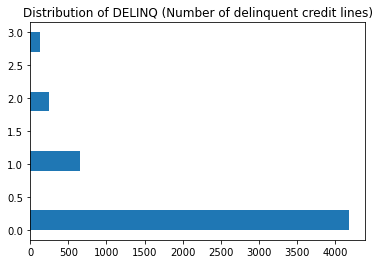

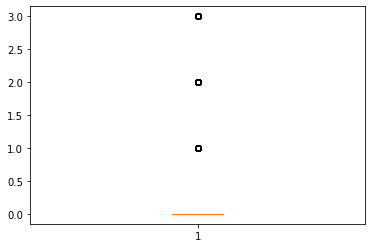



Share of outliers in CLAGE (Age of oldest credit line in months) is 0.05671140939597319
Mass of outliers in CLAGE (Age of oldest credit line in months) is 0.01809502284743114
numeric


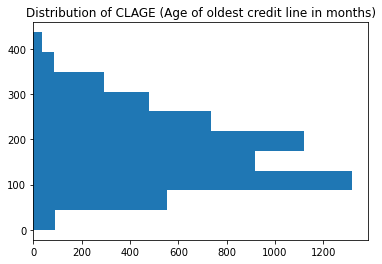

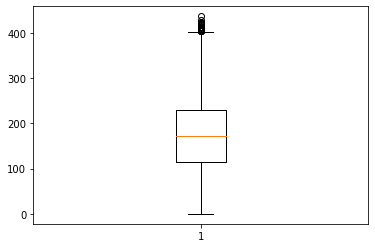



Share of outliers in NINQ (Number of recent credit inquiries) is 0.10587248322147647
Mass of outliers in NINQ (Number of recent credit inquiries) is 0.16305693069306926
numeric


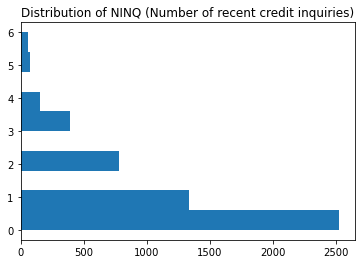

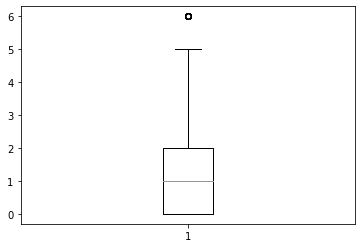



Share of outliers in DEBTINC (Debt-to-income ratio) is 0.21711409395973158
Mass of outliers in DEBTINC (Debt-to-income ratio) is 0.014319138268507503
numeric


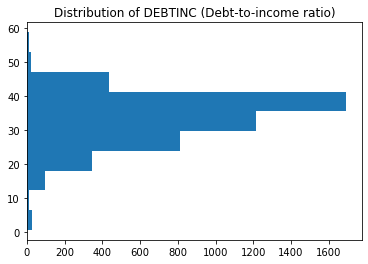

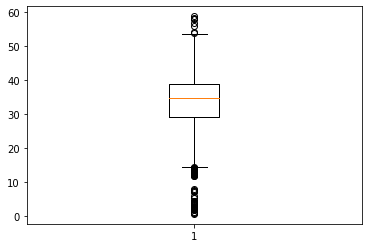

In [28]:
objects_with_outliers = ["LOAN", "MORTDUE", "VALUE", "DEROG", "DELINQ", "CLAGE", "NINQ", "DEBTINC"]

for column_with_outliers_name in objects_with_outliers:
    object_without_outliers = X_cat[column_with_outliers_name][X_cat[column_with_outliers_name].isnull() == False][stats.zscore(X_cat[column_with_outliers_name][X_cat[column_with_outliers_name].isnull() == False]) < 3]
    print(f"\n\nShare of outliers in {column_with_outliers_name} ({names_mask[column_with_outliers_name]}) is {1 - len(object_without_outliers) / X_cat.shape[0]}")
    print(f"Mass of outliers in {column_with_outliers_name} ({names_mask[column_with_outliers_name]}) is {1 - (object_without_outliers.sum()) / X_cat[column_with_outliers_name][X_cat[column_with_outliers_name].isnull() == False].sum()}")
    
    plot_all(object_without_outliers, column_with_outliers_name, names_mask)
    
    plt.boxplot(object_without_outliers)
    plt.show()

### Выводы

Небольшой аккуратный датасет. Пропусков не очень много, но они присутствуют во всех переменных. То же касается аутлаеров: в большинстве случаев их количество не критично, но есть они почти везде. Можно сделать вывод, что методики работы с пропусками и с аутлаерами в этом случае будут иметь большое значение. 